In [75]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch

In [37]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.3.1+cu118
cuda:0


In [38]:
data = datasets.fetch_california_housing()
data

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [39]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.DataFrame(data['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
n_features = X_train.shape[1]
print(X_train.shape)

(16512, 8)


### Basic data analysis
Here we just look at the correlation matrix

<Axes: >

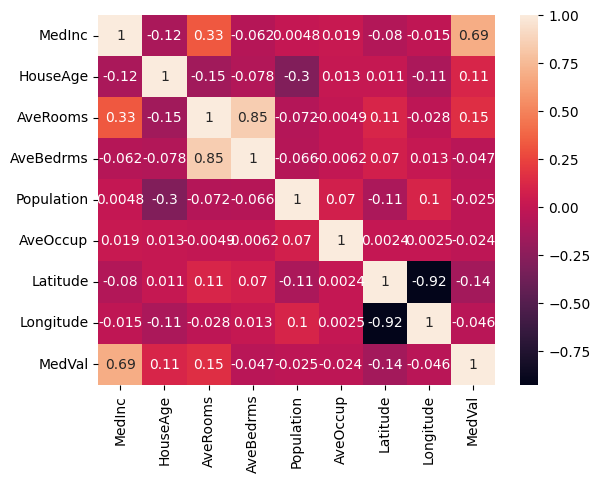

In [40]:
X['MedVal'] = y
sns.heatmap(X.corr(), annot=True)

### PyTorch modeling setup
Defining classes for our PyTorch MLP. \
`torch.utils.data.Dataset` stores samples and their corresponding labels. \
`torch.utils.data.DataLoader` wraps an iterable around the `Dataset` to enable easy access to  samples.

In [41]:
# The data  class: instructs model how to interact with out dataset
class DataMaker(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Define a scaler for normalization of the data
        scaler = StandardScaler()
        self.X = torch.tensor(scaler.fit_transform(X.astype(np.float32)),  dtype=torch.float32)
        self.y = torch.tensor(y.values,  dtype=torch.float32)
    def __getitem__(self, i):
        return self.X[i, :], self.y[i]
    def __len__(self):
        return len(self.X)

In [42]:
class MLP(torch.nn.Module):
    def __init__(self, dim, hidden_size):
        super().__init__()
        # Define model layers (3 layers, 2 sets of weights)
        self.linearInput = torch.nn.Linear(dim, hidden_size)
        self.linearHidden = torch.nn.Linear(hidden_size, 1)
        # Define activation function (ReLU - nonlinear activation function)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        return torch.nn.Sequential(self.linearInput, self.activation, self.linearHidden)(x)
    

In [61]:
train = DataMaker(X_train,y_train)
test = DataMaker(X_test,y_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=5000)
test_loader = torch.utils.data.DataLoader(test, batch_size=100)

In [54]:
%%time
mlp = MLP(n_features, 32).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
train_loss = []
for epoch in range(100):
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # zero out gradient
        optimizer.zero_grad()
        # feed the MLP the data
        out = mlp(inputs)
        # get average loss for batch
        loss = criterion(out, labels)
        running_loss+=loss.item()
        # do back propogation
        loss.backward()
        # update the weights using the gradients from the back propogation
        optimizer.step()
    train_loss.append(running_loss/len(train_loader))

CPU times: total: 2.77 s
Wall time: 9.58 s


<Axes: >

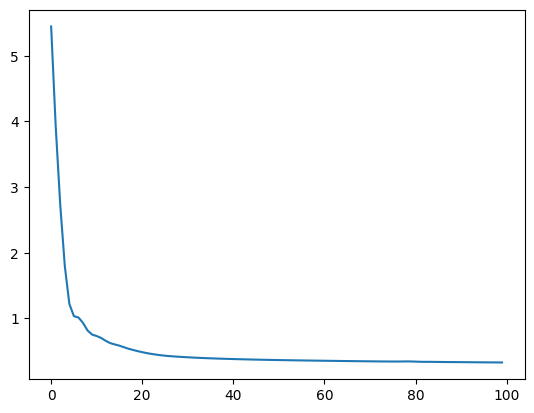

In [55]:
sns.lineplot(train_loss)

In [73]:
#### Get test MSE
test_loss = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # get nn output
        out = mlp(inputs)
        # get average loss for batch
        loss = criterion(out, labels)
        test_ = out - labels
        running_loss+=loss.item()
        test_loss.append(loss)

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [69]:
diff

tensor([[ 0.3996],
        [-0.6661],
        [-0.0141],
        [-0.7472],
        [-0.3871],
        [ 0.1551],
        [-0.9142],
        [ 0.7220],
        [-0.2545],
        [ 0.1573],
        [ 0.0235],
        [ 0.3246],
        [ 0.2453],
        [ 1.5893],
        [-0.3653],
        [-0.1175],
        [-0.9297],
        [ 0.2592],
        [ 0.3959],
        [ 0.0186],
        [ 0.0352],
        [ 0.4972],
        [ 0.5373],
        [ 0.0145],
        [ 0.1374],
        [ 0.0127],
        [-0.0412],
        [ 0.3853]], device='cuda:0')